# Emotion Detection

## Importing Libraries

In [3]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.17.0


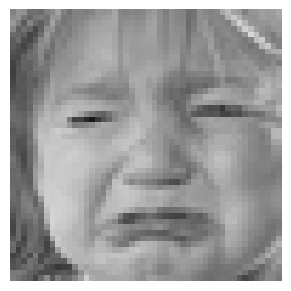

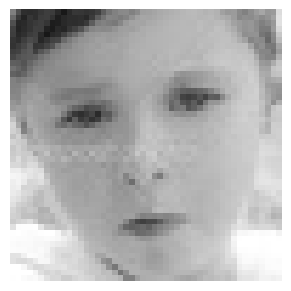

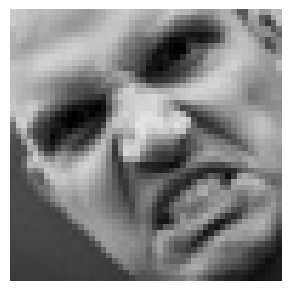

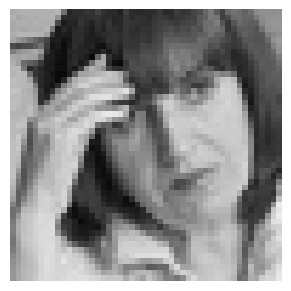

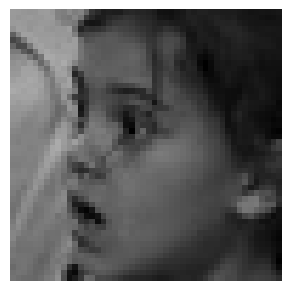

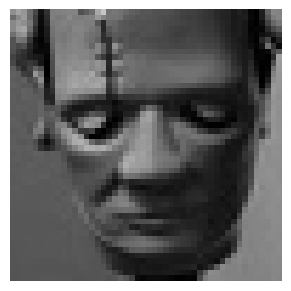

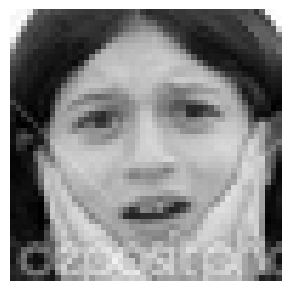

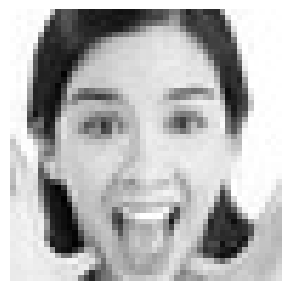

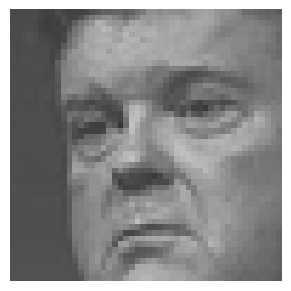

In [4]:
images=glob("train/**/**")
for i in range(9):
    image=random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

# Preparing Code for running

In [21]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator()
train_generator=datagen_train.flow_from_directory("train/",
                                                  target_size=(img_size,img_size),
                                                  color_mode="grayscale",
                                                  batch_size = batch_size,
                                                  class_mode="categorical",
                                                  shuffle= True)
datagen_validation=ImageDataGenerator()
validation_generator=datagen_train.flow_from_directory("test/",
                                                   target_size=(img_size,img_size),
                                                   color_mode="grayscale",
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Defining Model

In [8]:
def Convolution(input_tensor,filters,kernel_size):
    x=Conv2D(filters=filters,kernel_size=kernel_size,padding="same")(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.25)(x)

    return x

In [9]:
def Dense_f(input_tensor, nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)

    return x

In [10]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=Convolution(inputs,32,(3,3))
    conv_2=Convolution(inputs,64,(5,5))
    conv_3=Convolution(inputs,128,(3,3))

    flatten=Flatten()(conv_3)

    dense_1=Dense_f(flatten,256)
    output= Dense(7,activation="softmax")(dense_1)
    model=Model(inputs=[inputs], outputs=[output])
    model.compile(loss=['categorical_crossentropy'], optimizer='adam',metrics=['accuracy'])
    return model

In [11]:
model=model_fer((48,48,1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

# Initializing the Model

In [25]:
epochs=15
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size
checkpoint=ModelCheckpoint("model_weight.weights.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks=[checkpoint]

# Training the Model

## The next cell takes time to complete

In [31]:
history=model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks)

Epoch 1/15


C:\Users\abhir\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3282 - loss: 1.8397
Epoch 1: saving model to model_weight.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.3283 - loss: 1.8393 - val_accuracy: 0.3018 - val_loss: 2.0548
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:28 735ms/step - accuracy: 0.3906 - loss: 1.5215
Epoch 2: saving model to model_weight.weights.h5


C:\Users\abhir\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3906 - loss: 1.5215 - val_accuracy: 0.3000 - val_loss: 1.5456
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4943 - loss: 1.3479
Epoch 3: saving model to model_weight.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 641s 1s/step - accuracy: 0.4943 - loss: 1.3479 - val_accuracy: 0.4181 - val_loss: 1.5008
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:38 623ms/step - accuracy: 0.5312 - loss: 1.2910
Epoch 4: saving model to model_weight.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 1.2910 - val_accuracy: 0.4000 - val_loss: 1.5168
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.5640 - loss: 1.1675
Epoch 5: saving model to model_weight.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.5639 - loss: 1.1676 - val_accuracy: 0.4435 - val_loss: 1.4410
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:33 611ms/step - accuracy: 0.4531 - loss: 1.2966
Epoch 6: saving model to model

## Model Evaluation

In [33]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 377ms/step - accuracy: 0.4704 - loss: 1.6394


[1.653570532798767, 0.4661465585231781]

## Plotting Loss

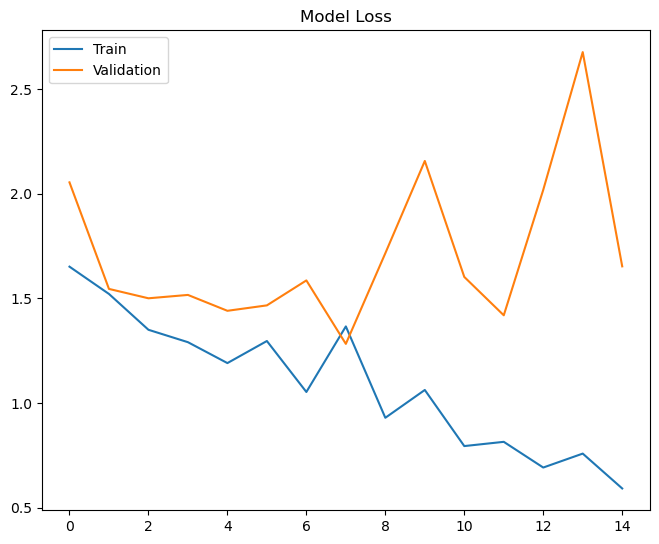

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [45]:
model_json=model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)